# I. Importing Data

In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.style.use('seaborn')

#setting matplotlib parameters
params = {'axes.titlesize':'20',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
         'axes.labelsize': '14',
         'legend.fontsize': '14'}
mpl.rcParams.update(params)

In [2]:
semester_names = ['spring', 'summer', 'fall']
dow_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

c = pd.read_csv('../Data/crime_data_clean.csv', index_col='time', parse_dates=True)

#setting semester as categorical datatype to maintain correct order
c['semester'] = c['semester'].astype(pd.api.types.CategoricalDtype(
    categories = semester_names, ordered=True))

c.head()

,code,description,disposition,location,patrol_zone,landmark,lat,long,year,month,...,inc_15_25,inc_25_35,inc_35_50,inc_50_75,inc_75_100,inc_100_150,inc_150_200,inc_greater_200,inc_median,inc_mean
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:36:00,7399,Miscellaneous Offenses,NaN,NONCAM,Z4,NaN,33.773124,-84.403163,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 01:55:00,7399,Miscellaneous Offenses,NaN,ONCAMRES,Z1,Center Street Apartments North,0.000000,0.000000,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 02:00:00,2308,Larceny - From Building,NaN,NONCAM,Z2,Sigma Nu Fraternity,33.775556,-84.394180,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 12:00:00,2204,Burglary - No Forced Entry - Residence,Unfounded,ONCAMRES,Z2,North Avenue Apartments North Building,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-02 06:15:00,7399,Miscellaneous Offenses,NaN,ONCAM,Z2,North Avenue Apartments,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299


# II. Feature Engineering

In [3]:
#creating features dataframe
non_features = ['code', 'lat', 'long', 'day_of_year', 'day_of_month', 'day_of_week', 'hour']
f = c.groupby(['year', 'month']).mean().drop(columns=non_features)
f['num_crimes'] = c.groupby(['year', 'month']).size()

#creating entries for the rest of 2018 to forecast
for month in range(7, 13):
    f.loc[(2018, month), :] = f.loc[(2018, 7), :].copy()

#estimating enrollment for fall 2018
pct_change = (f.loc[(2017, 8), 'enrollment'] - f.loc[(2016, 8), 'enrollment'])/f.loc[(2016, 8), 'enrollment']
f.loc[(2018, slice(8, 13)), 'enrollment'] = (f.loc[(2017, slice(8, 13)), 'enrollment']*(1+pct_change)).values

#creating 12 columns of lagged number of crimes
for month in range(1, 13):
    f['past_num_crimes_{}'.format(month)] = f['num_crimes'].shift(month)

f = f.reset_index()

#creating dummy variable to signify if the month is before 2012 fall semester
f['is_before_2012_fall'] = (f['year']<=2011) | ((f['year']==2012)&(f['month']<=8))
f['is_before_2012_fall'] = f['is_before_2012_fall'].astype(int)

f.head()

,year,month,enrollment,pop_total,pop_male,pop_female,pop_under_5,pop_5_9,pop_10_14,pop_15_19,...,past_num_crimes_4,past_num_crimes_5,past_num_crimes_6,past_num_crimes_7,past_num_crimes_8,past_num_crimes_9,past_num_crimes_10,past_num_crimes_11,past_num_crimes_12,is_before_2012_fall
0,2010,1,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2010,2,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2010,3,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2010,4,18879.00000,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2010,5,10831.23301,413462.0,205715.0,207747.0,26619.0,22606.0,19818.0,30806.0,...,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
def day_counter(yr, day_of_week):
    """Calculates counts of a given day of the week in each month for a given year
    yr: integer of a year to find counts of
    day_of_week: name of the day of week to find counts of
    returns DataFrame with a column of the count for the day indexed by year, month"""
    
    day_counts = np.zeros(12)
    date = datetime.date(yr, 1, 1)
    
    while date.year == yr:
        month = date.month
        weekday = date.weekday()
        if weekday == day_of_week:
            day_counts[month-1] += 1
        date = date + datetime.timedelta(days=1)
    
    counts_dict = {'year': [yr for i in range(12)],
                   'month': [i for i in range(1, 13)],
                   'count': day_counts}
    counts_df = pd.DataFrame(counts_dict).set_index(['year', 'month'])
    
    return counts_df

#sunday_counts = [day_counter(yr, 6) for yr in range(2010, 2018)] + [day_counter(2018, 6).iloc[:6]]
sunday_counts = [day_counter(yr, 6) for yr in range(2010, 2019)]
sunday_counts = pd.concat(sunday_counts).reset_index(drop=True)
f['num_sundays'] = sunday_counts
f['num_sundays'].head()

0    5.0
1    4.0
2    4.0
3    4.0
4    5.0
Name: num_sundays, dtype: float64

In [5]:
month_dummies = pd.get_dummies(f['month'], prefix='is_month', drop_first=True)
f[month_dummies.columns] = month_dummies

f[month_dummies.columns].head()

,is_month_2,is_month_3,is_month_4,is_month_5,is_month_6,is_month_7,is_month_8,is_month_9,is_month_10,is_month_11,is_month_12
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [6]:
prop_df = c.groupby(['month', 'day_of_week']).size().unstack()
prop_df = prop_df.div(prop_df.sum(axis='columns'), axis='rows')
prop_df.columns = ['prop_' + name for name in dow_names]

f = f.merge(prop_df[['prop_sunday']],
            left_on='month', right_index=True, how='left')
prop_df.head()

,prop_monday,prop_tuesday,prop_wednesday,prop_thursday,prop_friday,prop_saturday,prop_sunday
month,,,,,,,
1,0.132004,0.137702,0.131054,0.124406,0.155745,0.169041,0.150047
2,0.129170,0.122327,0.134303,0.139435,0.187340,0.164243,0.123182
3,0.115833,0.138333,0.152500,0.155000,0.170833,0.160833,0.106667
4,0.130961,0.135503,0.119606,0.143073,0.189251,0.152914,0.128690
5,0.114194,0.146211,0.132337,0.157951,0.184632,0.160085,0.104589


In [7]:
pop_df = c[['year', 'pop_total', 'pop_15_19']].drop_duplicates().set_index('year')
pop_df['prop_15_19'] = pop_df['pop_15_19'].div(pop_df['pop_total'])

f = f.merge(pop_df[['prop_15_19']],
            left_on='year', right_index=True, how='left')

pop_df.head()

,pop_total,pop_15_19,prop_15_19
year,,,
2010,413462,30806,0.074507
2011,419250,30602,0.072992
2012,425931,29980,0.070387
2013,432589,29556,0.068324
2014,440641,29071,0.065974


In [8]:
f = f.set_index(['year', 'month'])
f.tail(12)

enrollment  pop_total  pop_male  pop_female  pop_under_5  \
year month                                                               
2018 1      28437.000000   471332.0  233407.0    237925.0      26519.0   
     2      28437.000000   471332.0  233407.0    237925.0      26519.0   
     3      28437.000000   471332.0  233407.0    237925.0      26519.0   
     4      28437.000000   471332.0  233407.0    237925.0      26519.0   
     5      18211.560000   471332.0  233407.0    237925.0      26519.0   
     6      14235.000000   471332.0  233407.0    237925.0      26519.0   
     7      14235.000000   471332.0  233407.0    237925.0      26519.0   
     8      30028.732144   471332.0  233407.0    237925.0      26519.0   
     9      32224.502104   471332.0  233407.0    237925.0      26519.0   
     10     32224.502104   471332.0  233407.0    237925.0      26519.0   
     11     32224.502104   471332.0  233407.0    237925.0      26519.0   
     12     32224.502104   471332.0  233407.0    237925.0      26519.0   

            pop_5_9  pop_10_14  pop_15_19  pop_20_24  pop_25_34     ...      \
year month                                                          ...       
2018 1      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     2      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     3      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     4      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     5      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     6      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     7      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     8      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     9      26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     10     26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     11     26187.0    24008.0    30220.0    43205.0    97284.0     ...       
     12     26187.0    24008.0    30220.0    43205.0    97284.0     ...       

            is_month_5  is_month_6  is_month_7  is_month_8  is_month_9  \
year month                                                               
2018 1               0           0           0           0           0   
     2               0           0           0           0           0   
     3               0           0           0           0           0   
     4               0           0           0           0           0   
     5               1           0           0           0           0   
     6               0           1           0           0           0   
     7               0           0           1           0           0   
     8               0           0           0           1           0   
     9               0           0           0           0           1   
     10              0           0           0           0           0   
     11              0           0           0           0           0   
     12              0           0           0           0           0   

            is_month_10  is_month_11  is_month_12  prop_sunday  prop_15_19  
year month                                                                  
2018 1                0            0            0     0.150047    0.064116  
     2                0            0            0     0.123182    0.064116  
     3                0            0            0     0.106667    0.064116  
     4                0            0            0     0.128690    0.064116  
     5                0            0            0     0.104589    0.064116  
     6                0            0            0     0.118573    0.064116  
     7                0            0            0     0.112922    0.064116  
     8                0            0            0     0.122760    0.064116  
     9                0            0            0     0.091238 

In [9]:
f.describe()

,enrollment,pop_total,pop_male,pop_female,pop_under_5,pop_5_9,pop_10_14,pop_15_19,pop_20_24,pop_25_34,...,is_month_5,is_month_6,is_month_7,is_month_8,is_month_9,is_month_10,is_month_11,is_month_12,prop_sunday,prop_15_19
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,20255.866575,441371.000000,218533.222222,222837.777778,27019.333333,23287.333333,21816.666667,29795.444444,44294.222222,87551.333333,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.112406,0.067662
std,6267.783655,19148.422756,9021.853876,10149.986111,428.846747,1372.536910,1478.276491,635.129913,1717.200141,6112.922057,...,0.277674,0.277674,0.277674,0.277674,0.277674,0.277674,0.277674,0.277674,0.018986,0.003878
min,8822.000000,413462.000000,205715.000000,207747.000000,26519.000000,22114.000000,19818.000000,28852.000000,41124.000000,77791.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071325,0.064116
25%,18712.140000,425931.000000,211553.000000,214378.000000,26713.000000,22332.000000,20451.000000,29308.000000,43205.000000,83167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104083,0.064219
50%,20726.000000,440641.000000,217938.000000,222703.000000,26903.000000,22606.000000,21576.000000,29764.000000,44330.000000,86918.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114622,0.065974
75%,24150.916667,456378.000000,225203.000000,231175.000000,27123.000000,23905.000000,23094.000000,30220.000000,45455.000000,92214.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122865,0.070387
max,32224.502104,471332.000000,233407.000000,237925.000000,27976.000000,26187.000000,24008.000000,30806.000000,46580.000000,97284.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.150047,0.074507


# III. Training Regression Models

Now that we have the data in a form we can work with, it's time to try to fit a regression model to our data.

### A. Preliminary Work

In [10]:
import itertools
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
#creating several functions to simplify plotting results for various models

def plot_fit(y_obs, y_pred, ax, test=False, test_mse=0):
    ax.scatter(x=range(len(y_obs)), y=y_obs, c='b')
    ax.plot(y_pred, c='k', linestyle='--')
    ax.set_title('Regression with Prediction Intervals')
    ax.set_ylabel('Number of Crimes')
    ax.set_xticks(range(0, len(y_obs)+6, 12))
    ax.set_xticklabels(range(2010, 2019))
    mse = mean_squared_error(y_obs, y_pred)
    if test:
        mse = test_mse
        ax.set_xticklabels(range(2016, 2020))

    y_upper_20 = y_pred + .253*np.sqrt(mse)
    y_lower_20 = y_pred - .253*np.sqrt(mse)
    y_upper_80 = y_pred + 1.28*np.sqrt(mse)
    y_lower_80 = y_pred - 1.28*np.sqrt(mse)
    y_upper_95 = y_pred + 1.96*np.sqrt(mse)
    y_lower_95 = y_pred - 1.96*np.sqrt(mse)
    
    size = len(y_obs)
    #plotting prediction intervals
    ax.fill(list(range(size)) + list(range(size-1, -1, -1)),
            np.concatenate((y_upper_20, y_lower_20[::-1])),
            alpha=0.3, color='k', label='20% Prediction Interval')
    ax.fill(list(range(size)) + list(range(size-1, -1, -1)),
            np.concatenate((y_upper_80, y_lower_80[::-1])),
            alpha=0.2, color='k', label='80% Prediction Interval')
    ax.fill(list(range(size)) + list(range(size-1, -1, -1)),
            np.concatenate((y_upper_95, y_lower_95[::-1])),
            alpha=0.1, color='k', label='95% Prediction Interval')

    ax.legend()
    return ax

def plot_residuals(y_obs, y_pred, ax, standardized=True, test=False):
    residuals = y_obs - y_pred
    size = len(residuals)
    if standardized:
        residuals = (residuals)/np.std(residuals)
    data = ax.scatter(x=range(size), y=residuals, c='b')
    ax.set_xticks(range(0, size+6, 12))
    ax.set_xticklabels(range(2010, 2019))
    ax.set_xlim(-3, size+3)
    ax.set_ylim(-3.9, 3.9)
    ax.axhline(0, color='k', linestyle='--', alpha=0.5)
    ax.set_title('Residuals Plot')
    ax.set_ylabel('Standardized Residuals')
    if test:
        ax.set_xticklabels(range(2016, 2020))
    return ax

def plot_observed_predicted(y_obs, y_pred, ax):
    data = ax.scatter(x=y_obs, y=y_pred, c='b')
    vals = np.concatenate((y_obs, y_pred))
    lower = np.min(vals) - 5
    upper = np.max(vals) + 5
    ax.plot([lower, upper], [lower, upper], color='k', alpha=0.4, linestyle='--')
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    ax.set_title('Observed vs Predicted Plot')
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values - autoregression')
    return ax

def plot_qq(y_obs, y_pred, ax):
    residuals = np.sort(y_obs - y_pred)
    size = len(residuals)
    percentiles = np.linspace(1/(size+1), 1, size, endpoint=False)
    x = stats.norm.ppf(percentiles)
    y = (residuals - np.mean(residuals))/np.std(residuals)
    ax.scatter(x=x, y=y)
    ax.plot([-3, 3], [-3, 3], color='k', alpha=0.5, linestyle='--')
    ax.set_title('QQ Plot')
    ax.set_xlabel('Theoretical Normal Quantiles')
    ax.set_ylabel('Observed Residual Quantiles')
    return ax
    
def plot_summary(y_obs, y_pred, title=None, standardized=True, intervals=False, test=False):
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax = [ax1, ax2, ax3, ax4]
    plot_fit(y_obs, y_pred, ax[0], intervals, test)
    plot_residuals(y_obs, y_pred, ax[1], standardized, test)
    plot_observed_predicted(y_obs, y_pred, ax[2])
    plot_qq(y_obs, y_pred, ax[3])
    if title:
        plt.suptitle(title, fontsize=20)
    return ax

def summary_statistics(y_obs, y_pred, n, test=False):
    residuals = y_obs - y_pred
    mean = np.mean(y_obs)
    ss_r = np.square(residuals).sum()
    ss_t = np.square((y_obs - mean)).sum()
    r_squared = 1 - ss_r/ss_t
    mse = ss_r/len(y_obs)
    trends_obs = y_obs[1:] > y_obs[:-1]
    trends_pred = y_pred[1:] > y_pred[:-1]
    trends_correct = sum(trends_obs == trends_pred)
    trends_accuracy = round(trends_correct/(len(y_obs)-1), 4)
    print('MSE: {0:.{1}f}'.format(mse, 4))
    print('RMSE: {0:.{1}f}'.format(np.sqrt(mse), 4))
    print('R-squared: {0:.{1}f}'.format(r_squared, 4))
    if not test:
        adjusted_r_squared = 1 - (1-r_squared)*(len(y_obs)-1)/(len(y_obs)-n-1)
        print('Adjusted R-squared: {0:.{1}f}'.format(adjusted_r_squared, 4))
    print ('Trends accuracy: {} or {}/{}'.format(trends_accuracy, trends_correct, len(y_obs)-1))
    return mse, r_squared

In [12]:
#functions used for cross validation and hyperparameter tuning
def calc_fold_mse(pipeline, X, y, params):
    train_size = 48
    sample_size = len(y)
    errors = np.zeros(sample_size-train_size)
    y_pred = np.zeros(sample_size-train_size)
    i = 0
    pipeline.set_params(**params)
    while train_size < sample_size:       
        pipeline.fit(X[:train_size], y[:train_size])
        y_pred[i] = pipeline.predict(X[train_size].reshape(1, -1))
        errors[i] = y[train_size] - y_pred[i]
        train_size += 1
        i += 1
    mse = np.square(errors).sum()/len(errors)
    return mse

def grid_search_cv(pipeline, X, y, param_names, param_vals):
    best_mse = np.inf
    best_params = None
    for comb in itertools.product(*param_vals):
        params = {name:val for name, val in zip(param_names, comb)}
        mse = calc_fold_mse(pipeline, X, y, params)
        if mse < best_mse:
            best_mse = mse
            best_params = params
    return best_params, best_mse

Let's split our data into training and test sets, and plot the results.

We can use 2010-2015 as training data, and 2016-2018 as test data.

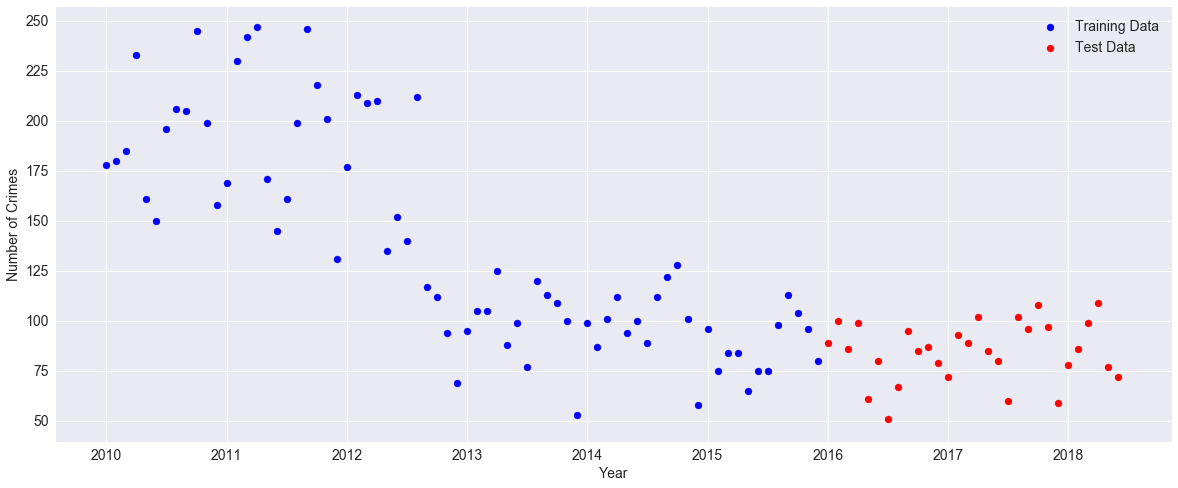

In [13]:
#extracting data
X = f.drop(columns='num_crimes').iloc[:-6]
y = f['num_crimes'].iloc[:-6].values

#splitting into training and test data
X_train = X[:72].values
y_train = y[:72]
X_test = X[72:].values
y_test = y[72:]

#plotting
plt.figure(figsize=(20, 8))
plt.scatter(x = range(len(y_train)), y = y_train, color='b')
plt.scatter(x = range(len(y_train), len(y_train)+len(y_test)), y = y_test, color='r')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(['Training Data', 'Test Data'])
plt.xticks(range(0, len(y_train)+len(y_test), 12), range(2010, 2019))
plt.show()

### B. Linear Regression

#### 1. Preliminary Fitting and Testing Model Assumptions

We will start by creating a pipeline for our preliminary linear model, fitting it to the training data, and predicting the training data using our model.

MSE: 161.3966
RMSE: 12.7042
R-squared: 0.9447
Adjusted R-squared: 0.7384
Trends accuracy: 0.7465 or 53/71


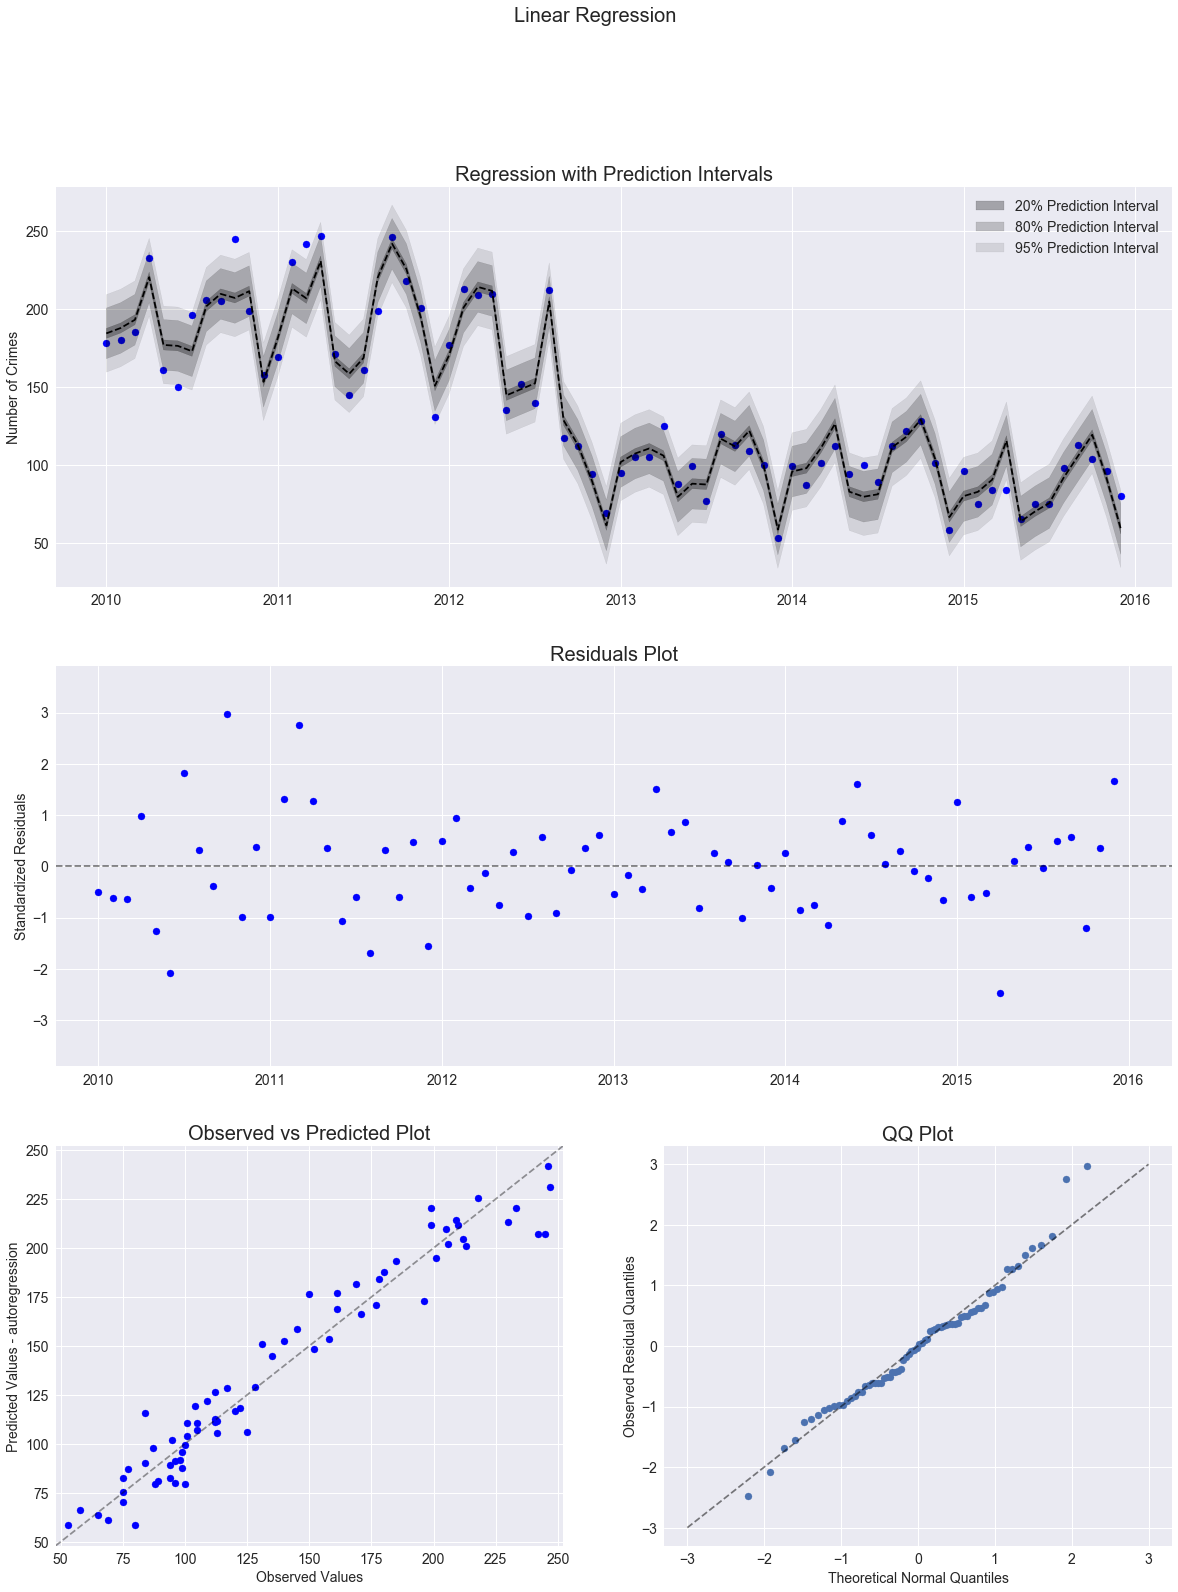

In [14]:
#creating up transformations for pipelines
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
scale = StandardScaler()

#training linear regression
clf_lr = LinearRegression()
steps_lr = [('imputation', imp), ('scale', scale), ('regression', clf_lr)]
pipeline_lr = Pipeline(steps_lr)
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_train)


#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_lr, len(X_train[0]))
plot_summary(y_train, y_pred_lr, 'Linear Regression');

First, let's look at the top chart. The model appears to fit the data very well. The model captures the general decrease in crime throughout the years as well as the periodicity of the months throughout individual years. The residuals plot does not exhibit heteroscedasticity, and the QQ plot is close enough that we can assume normally distributed residuals. The observed vs predicted plot shows us that the model tends to predict equally well across all ranges of values. Overall, none of the assumptions required for a linear model are invalidated. A linear model seems like a good choice for the data.

There is, however, a significantly large disparity between our R-squared and our adjusted R-squared (0.9234 vs 0.6374). This implies that the model may be overfit to the training data and may not generalize well to data it hasn't seen well. Let's do some feature selection to maximize

We will want to do some feature selection to increase the adjusted R-squared value.

#### 2. Feature Selection

Since the features are standardized, we can look at the coefficients as a measure of how well a certain variable predicts number of crimes. Let's try removing the weakest predictors to increase the adjusted R-squared value and get rid of some of the overfitting.

In [15]:
#determining weak and strong predictor variables
coefs = {col: coef for col, coef in zip(X.columns, clf_lr.coef_)}
coefs = pd.Series(coefs)

#printing the weakest and strongest predictors
print('Strongest predictors:   abs(coefficent)')
print(np.abs(coefs).sort_values(ascending=False).head())

print('\nWeakest predictors:   abs(coefficent)')
print(np.abs(coefs).sort_values(ascending=False).tail())

Strongest predictors:   abs(coefficent)
is_before_2012_fall    42.962057
enrollment             19.581002
past_num_crimes_8      16.051123
is_month_7             13.404389
is_month_6             12.769827
dtype: float64

Weakest predictors:   abs(coefficent)
pop_45_54     0.064846
pop_female    0.055369
pop_65_74     0.028566
pop_total     0.019091
pop_25_34     0.002308
dtype: float64


Let's try recursive feature evaluation to drop less important predictors.

In [16]:
from sklearn.feature_selection import RFE

#setting up pipelien
rfe = RFE(clf_lr)
steps_rfe = [('imputation', imp), ('scale', scale), ('rfe', rfe)]
pipeline_rfe = Pipeline(steps_rfe)
pipeline_rfe.fit(X_train, y_train)
ranks = rfe.ranking_
#printing selected features
print('Most important Features:')
print(X.columns[ranks == 1])

Most important Features:
Index(['enrollment', 'pop_under_5', 'pop_45_54', 'pop_55_59', 'pop_75_84',
       'inc_10_15', 'inc_35_50', 'inc_50_75', 'inc_75_100', 'inc_100_150',
       'past_num_crimes_1', 'past_num_crimes_4', 'past_num_crimes_6',
       'past_num_crimes_8', 'past_num_crimes_11', 'past_num_crimes_12',
       'is_before_2012_fall', 'is_month_2', 'is_month_3', 'is_month_4',
       'is_month_5', 'is_month_6', 'is_month_7', 'is_month_8', 'is_month_9',
       'is_month_10', 'is_month_11', 'is_month_12'],
      dtype='object')


Now we can refit the linear regression with the updated feature matrix.

28 out of 56 features dropped

MSE: 172.4984
RMSE: 13.1339
R-squared: 0.9409
Adjusted R-squared: 0.9025
Trends accuracy: 0.7746 or 55/71


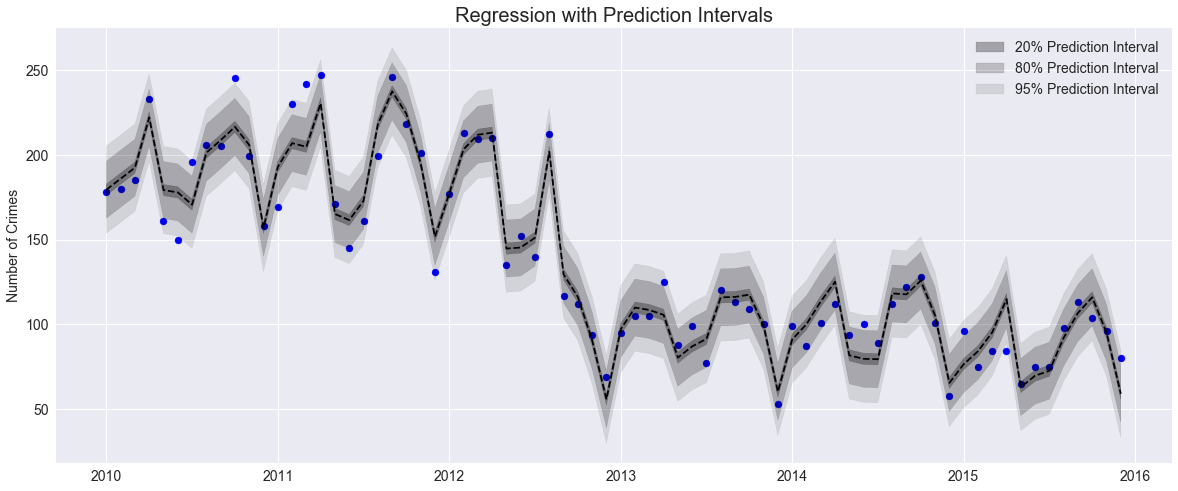

In [17]:
#recreating feature matrix, dropping bad predictors
print('{} out of {} features dropped\n'.format(sum(ranks!=1), len(X_train[0])))
X_fs = X.loc[:, ranks == 1]
X_train_fs = X_fs[:72].values
X_test_fs = X_fs[72:].values

#refitting
pipeline_lr.fit(X_train_fs, y_train)
y_pred_lr = pipeline_lr.predict(X_train_fs)

#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
summary_statistics(y_train, y_pred_lr, len(X_train_fs[0]))
plot_fit(y_train, y_pred_lr, ax);

We were able to drop 28 out of the total 56 features and only increase our RMSE by less than 3 percent. Our R-squared dropped less than 1 percent, while our adjusted R-squared climbed from 0.7384 to 0.9025. Additionally, our trends accuracy has increased slightly. This feature reduction has simplified our model significantly without losing much predictive power, and should generalize better to our test data now.

Even though a linear model appears to fit the data well, we will want to train some more sophisticated regression models, and in the end see which one predicts our test data the best. In total, we will train an elastic net regression, a support vector machine regression, a random forest regression, and a gradient boosting regression model. We will also train a simple autoregression model to use as a baseline for what our models should be able to beat.

For each model to follow, we will begin by initializing a pipeline for that model, and finding the best hyperparameters by grid search cross validation. Then we will train using those selected hyperparameters and the training data, and plot the fit and summary statistics.

### C. Elastic Net Regression

In [18]:
#creating pipeline for elastic net regression
steps_en = [('imputation', imp), ('scale', scale),
             ('regression', ElasticNet())]
pipeline_en = Pipeline(steps_en)

#hyperparameter tuning via grid search cross-validation
best_params_en, best_mse_en = grid_search_cv(pipeline_en, X_train, y_train,
                      param_names=['regression__alpha', 'regression__l1_ratio'],
                      param_vals=[np.logspace(-2, 10, 13, base=2), np.linspace(.01, 1, 10)])
print('Best MSE: {}'.format(best_mse_en))
print('Best RMSE: {}'.format(np.sqrt(best_mse_en)))
print('Best Parameters: {}'.format(best_params_en))

Best MSE: 189.15075215907703
Best RMSE: 13.753208795007696
Best Parameters: {'regression__alpha': 4.0, 'regression__l1_ratio': 0.01}


MSE: 683.5893
RMSE: 26.1455
R-squared: 0.7659
Adjusted R-squared: -0.1080
Trends accuracy: 0.6197 or 44/71


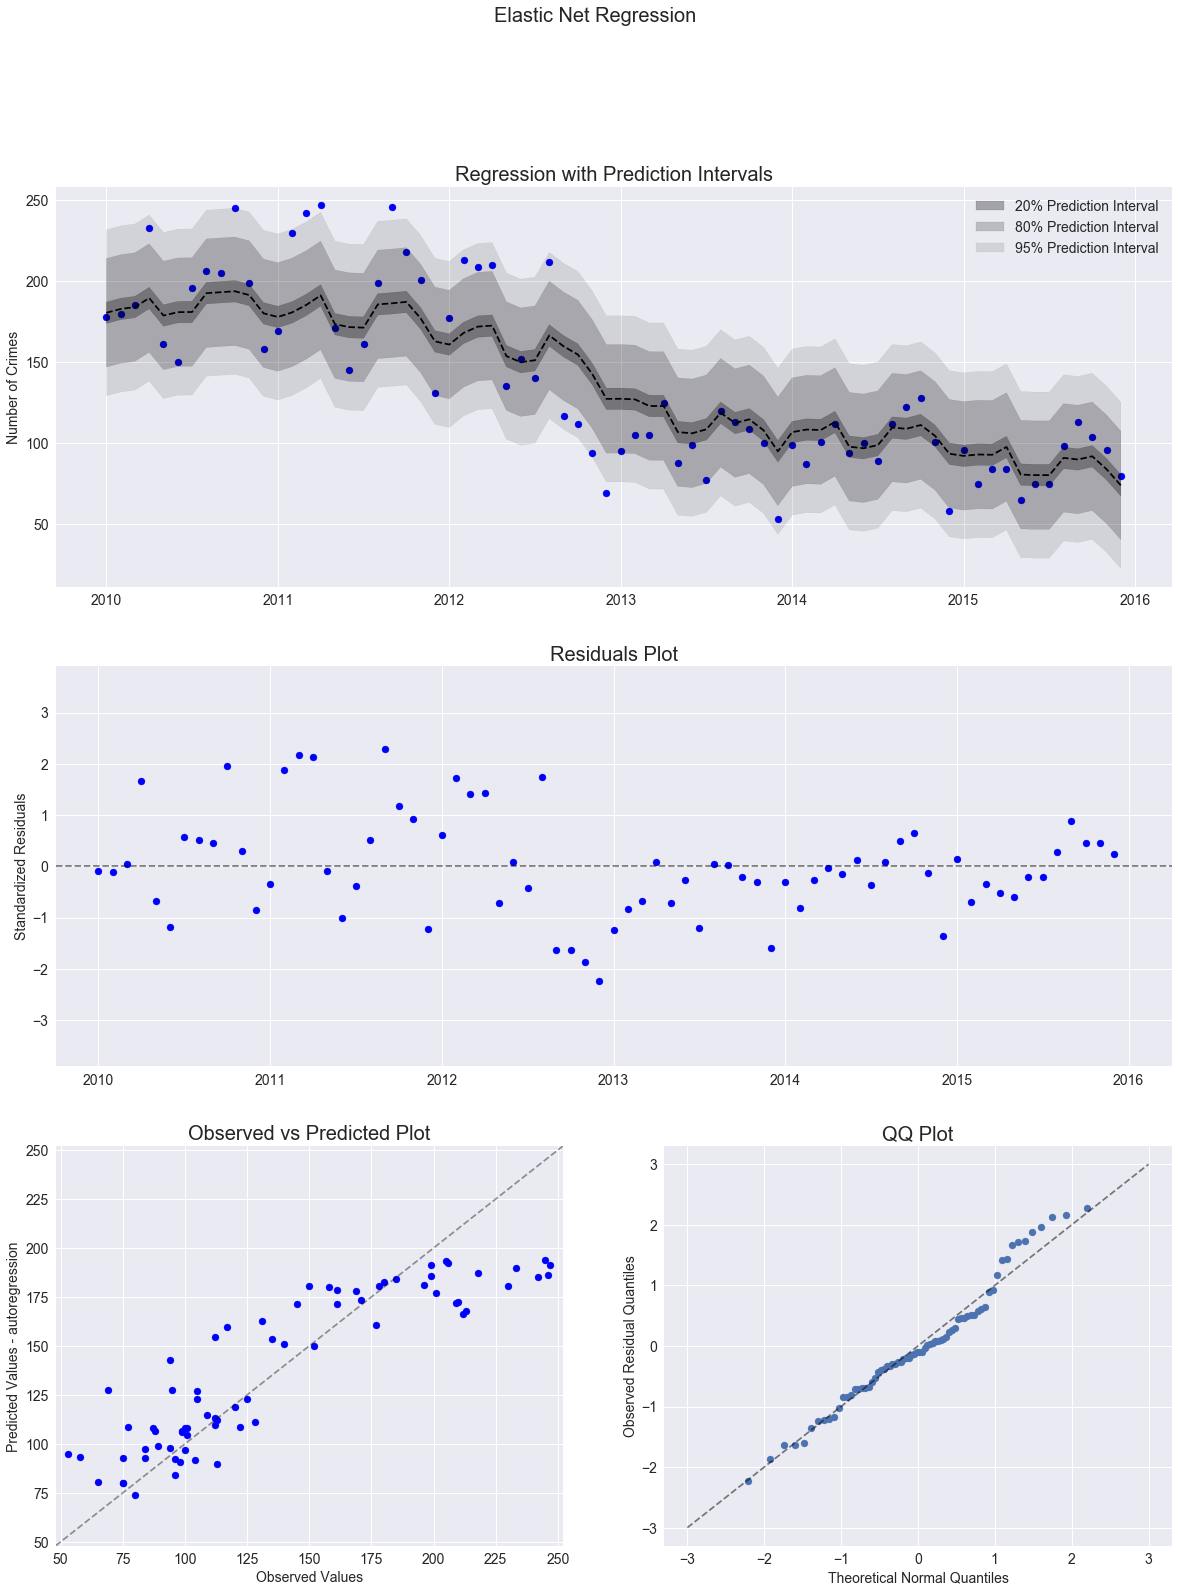

In [19]:
#setting hyperparameters, fitting model, and predicting training set
pipeline_en.set_params(**best_params_en)
pipeline_en.fit(X_train, y_train)
y_pred_en = pipeline_en.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_en, len(X_train[0]))
plot_summary(y_train, y_pred_en, 'Elastic Net Regression');

### D. Support Vector Machine Regression

In [20]:
#creating pipeline for support vector machine regression
steps_svr = [('imputation', imp), ('scale', scale),
             ('regression', SVR(kernel='linear'))]
pipeline_svr = Pipeline(steps_svr)

#hyperparameter tuning via grid search cross-validation
best_params_svr, best_mse_svr = grid_search_cv(pipeline_svr, X_train, y_train, 
                      param_names=['regression__C', 'regression__epsilon'],
                      param_vals=[np.logspace(-5, 5, 11, base=2), np.logspace(-5, 5, 11, base=2)])
print('Best MSE: {}'.format(best_mse_svr))
print('Best RMSE: {}'.format(np.sqrt(best_mse_svr)))
print('Best Parameters: {}'.format(best_params_svr))

Best MSE: 158.8485812418715
Best RMSE: 12.603514638459842
Best Parameters: {'regression__C': 0.25, 'regression__epsilon': 4.0}


MSE: 539.4770
RMSE: 23.2266
R-squared: 0.8153
Adjusted R-squared: 0.1256
Trends accuracy: 0.7887 or 56/71


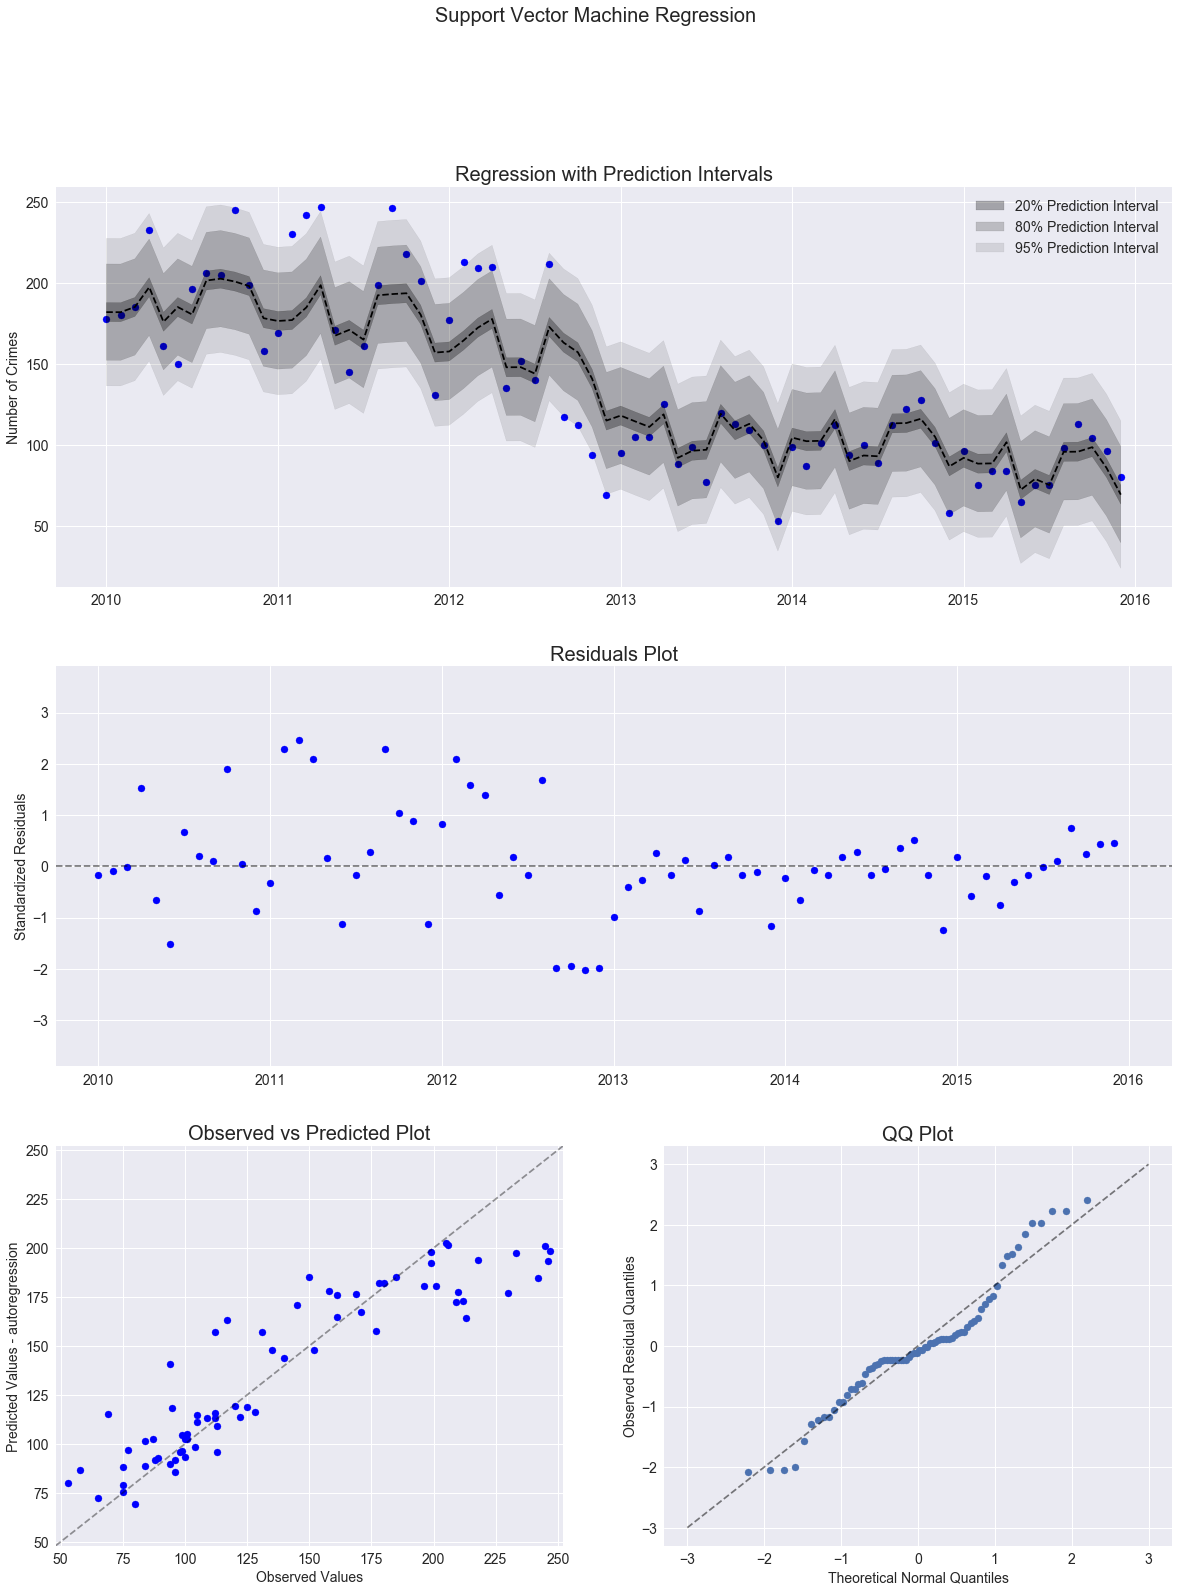

In [21]:
#setting hyperparameters, fitting model, and predicting training set
pipeline_svr.set_params(**best_params_svr)
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_svr, len(X_train[0]))
plot_summary(y_train, y_pred_svr, 'Support Vector Machine Regression');

### E. Random Forest Regression

In [22]:
#creating pipeline for random forest regression
steps_rf = [('imputation', imp), ('scale', scale),
             ('regression', RandomForestRegressor(random_state=0))]
pipeline_rf = Pipeline(steps_rf)

#hyperparameter tuning via grid search cross-validation
best_params_rf, best_mse_rf = grid_search_cv(pipeline_rf, X_train, y_train, 
                      param_names=['regression__n_estimators', 'regression__max_features'],
                      param_vals=[[1, 10, 100, 500], ['auto', 'sqrt', 'log2']])
print('Best MSE: {}'.format(best_mse_rf))
print('Best RMSE: {}'.format(np.sqrt(best_mse_rf)))
print('Best Parameters: {}'.format(best_params_rf))

Best MSE: 183.52541666666662
Best RMSE: 13.54715529794601
Best Parameters: {'regression__n_estimators': 10, 'regression__max_features': 'auto'}


MSE: 117.1329
RMSE: 10.8228
R-squared: 0.9599
Adjusted R-squared: 0.8102
Trends accuracy: 0.9014 or 64/71


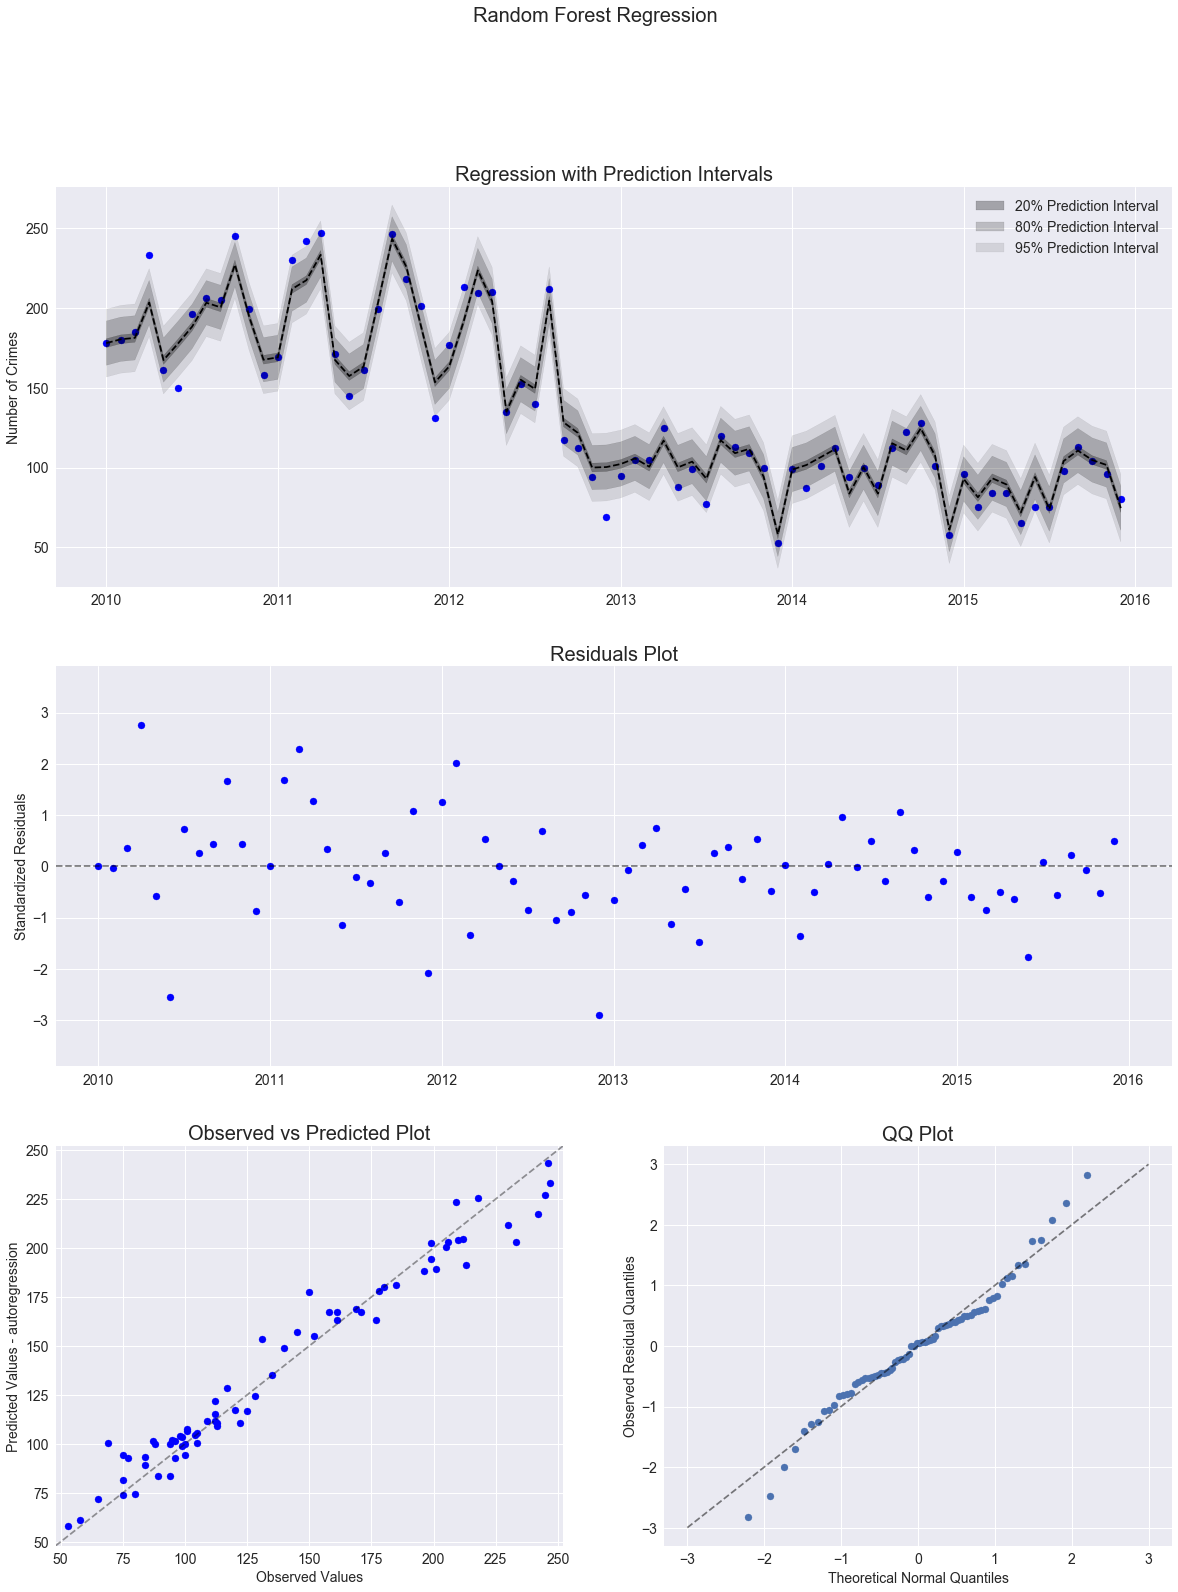

In [23]:
#setting hyperparameters, fitting model, and predicting training set
pipeline_rf.set_params(**best_params_rf)
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_rf, len(X_train[0]))
plot_summary(y_train, y_pred_rf, 'Random Forest Regression');

### F. Gradient Boosting Regression

In [24]:
#creating pipeline for gradient boosting regression
steps_gb = [('imputation', imp), ('scale', scale),
             ('regression', GradientBoostingRegressor(random_state=0))]
pipeline_gb = Pipeline(steps_gb)

#hyperparameter tuning via grid search cross-validation
best_params_gb, best_mse_gb = grid_search_cv(pipeline_gb, X_train, y_train, 
                      param_names=['regression__max_depth', 'regression__subsample', 'regression__max_features'],
                      param_vals=[[4, 6, 8, 10], [.5, .75, 1], [.4, .6, .8, 1]])
print('Best MSE: {}'.format(best_mse_gb))
print('Best RMSE: {}'.format(np.sqrt(best_mse_gb)))
print('Best Parameters: {}'.format(best_params_gb))

Best MSE: 149.05081429953702
Best RMSE: 12.20863687311311
Best Parameters: {'regression__max_depth': 10, 'regression__subsample': 0.5, 'regression__max_features': 0.8}


MSE: 0.2276
RMSE: 0.4771
R-squared: 0.9999
Adjusted R-squared: 0.9996
Trends accuracy: 0.9577 or 68/71


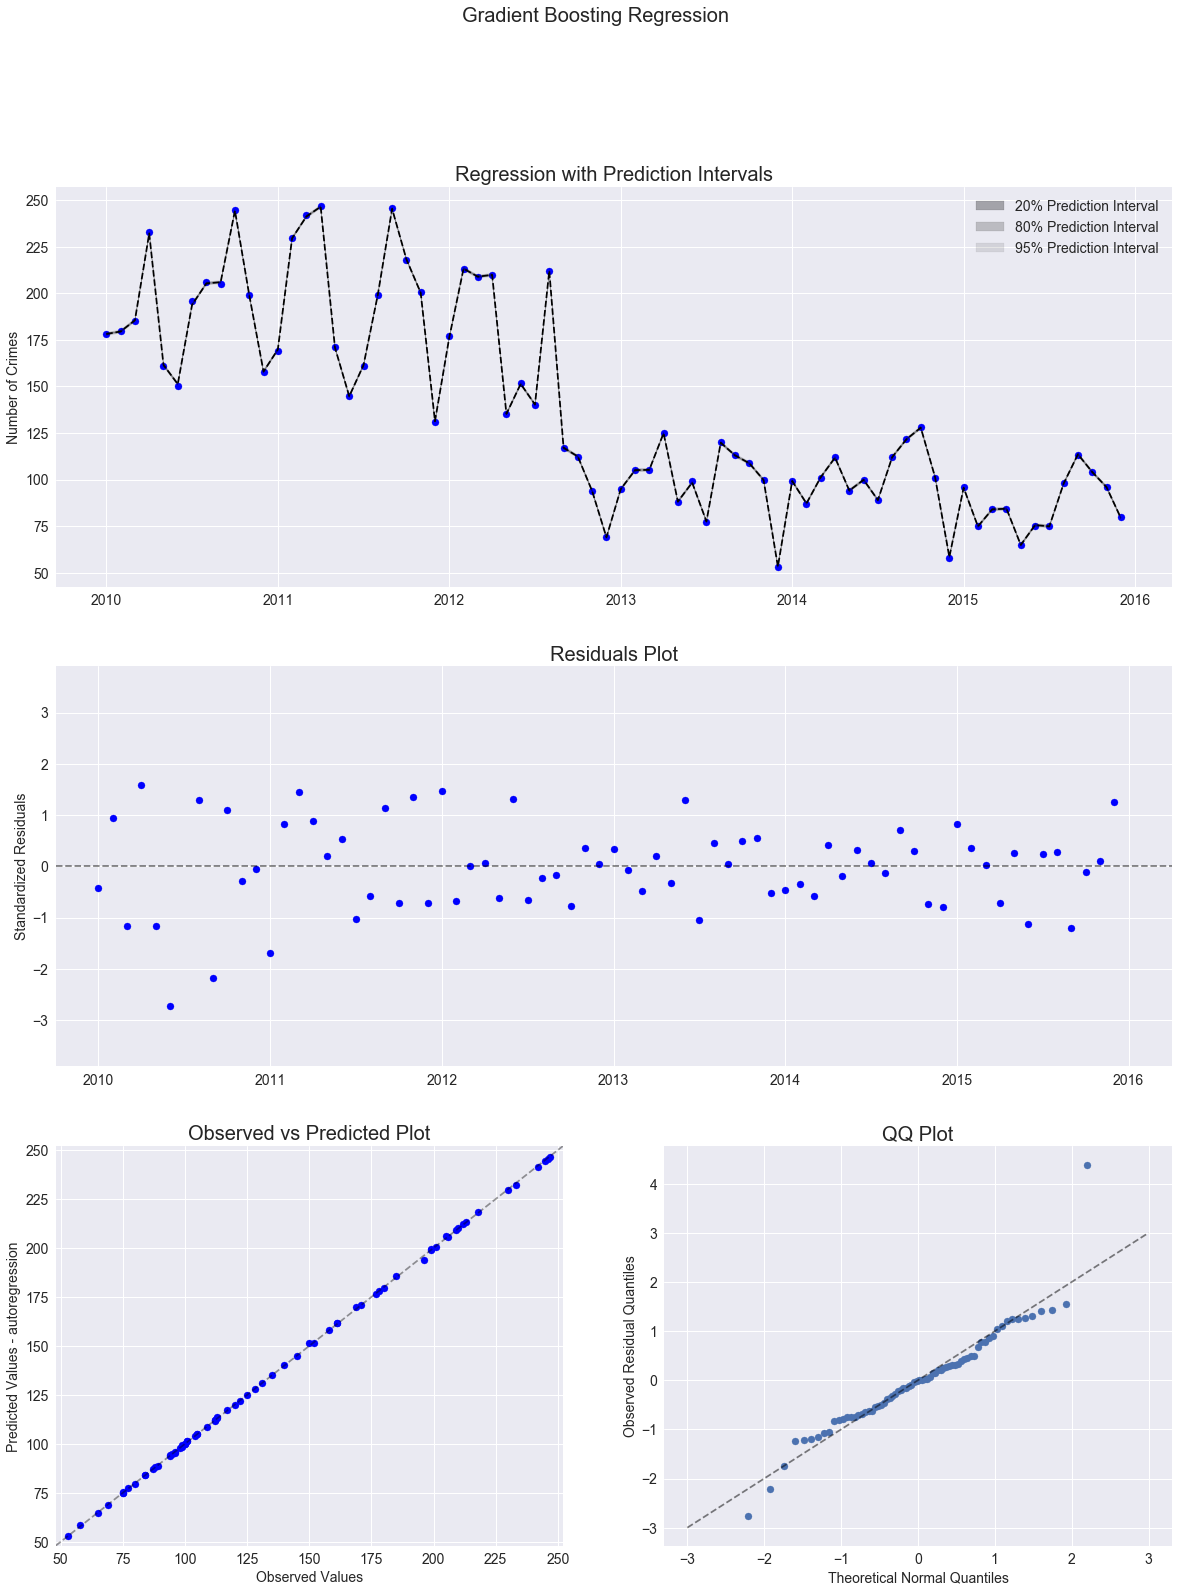

In [25]:
#setting hyperparameters, fitting model, and predicting training set
pipeline_gb.set_params(**best_params_gb)
pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_train)

#plotting results
fig = plt.figure(figsize=(20, 25))
summary_statistics(y_train, y_pred_gb, len(X_train[0]))
plot_summary(y_train, y_pred_gb, 'Gradient Boosting Regression');

# IV. Evaluating Regression Model Performance

Now that we have our models trained, it's time to fit to the test data and evaluate which one predicts the best.

### A. Linear Regression

MSE: 2261.7049
RMSE: 47.5574
R-squared: -9.1888
Trends accuracy: 0.6552 or 19/29


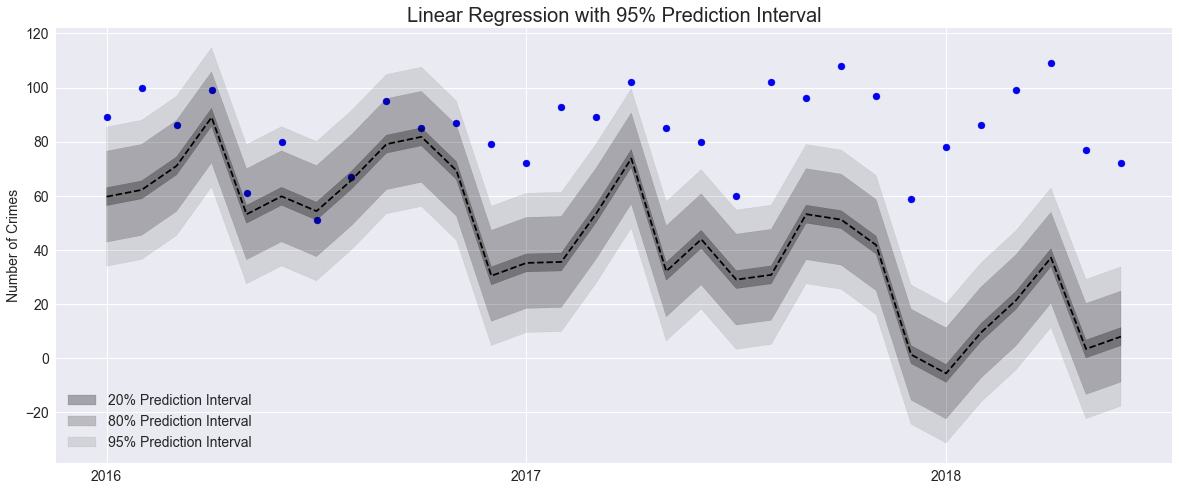

In [26]:
#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
pipeline_lr.fit(X_train_fs, y_train)
y_pred_lr = pipeline_lr.predict(X_test_fs)
summary_statistics(y_test, y_pred_lr, len(X_train_fs[0]), test=True)
plot_fit(y_test,y_pred_lr, ax, test=True, test_mse=172.49)
ax.set_title('Linear Regression with 95% Prediction Interval');

The linear regression model had a hard time eliminating the negative trend, even with the is_before_fall_2012 dummy variable. It appears to get the general shape right with a trend accuracy of 19/29, however it predicts consistently below the true number. It has a negative R-squared, which means that simply predicting the average number of crimes for each month performs better than our model. With an RMSE of around 47, we will want to reject this model in favor of a more sophisticated one.

### B. Elastic Net Regression

MSE: 417.4065
RMSE: 20.4305
R-squared: -0.8804
Trends accuracy: 0.7241 or 21/29


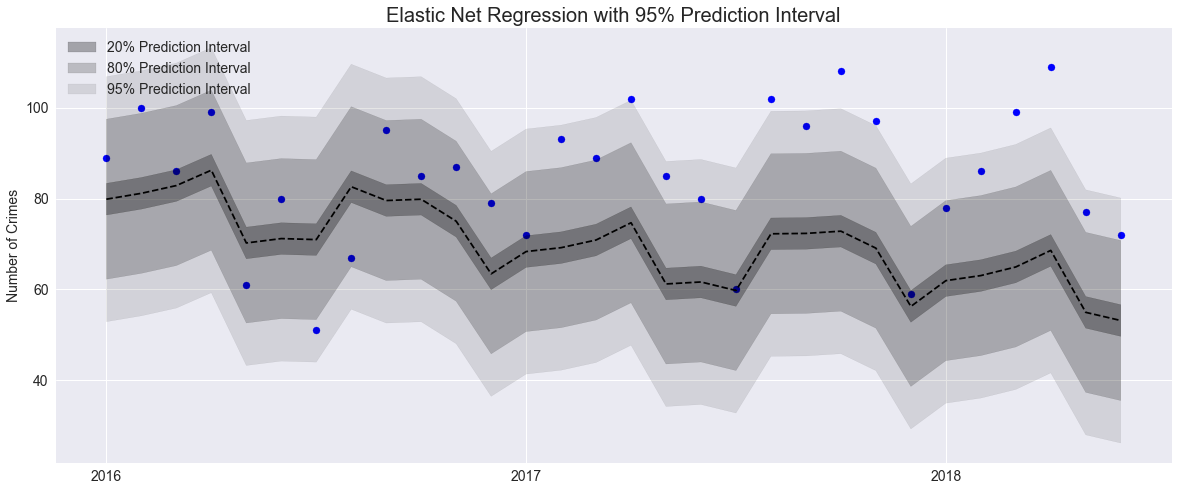

In [27]:
#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
pipeline_en.fit(X_train, y_train)
y_pred_en = pipeline_en.predict(X_test)
summary_statistics(y_test, y_pred_en, len(X_train[0]), test=True)
plot_fit(y_test, y_pred_en, ax=ax, test=True, test_mse=best_mse_en)
ax.set_title('Elastic Net Regression with 95% Prediction Interval');

The elastic net regression performs significantly better than our linear regression. It still has a negative R-squared, but its RMSE is significantly better - less than half of that of the linear regression. It also improves the trend accuracy to 21/29. Still, with the negative R-squared we will want to use a different model for our final predictions.

### C. Support Vector Machine Regression

MSE: 158.6139
RMSE: 12.5942
R-squared: 0.2855
Trends accuracy: 0.5862 or 17/29


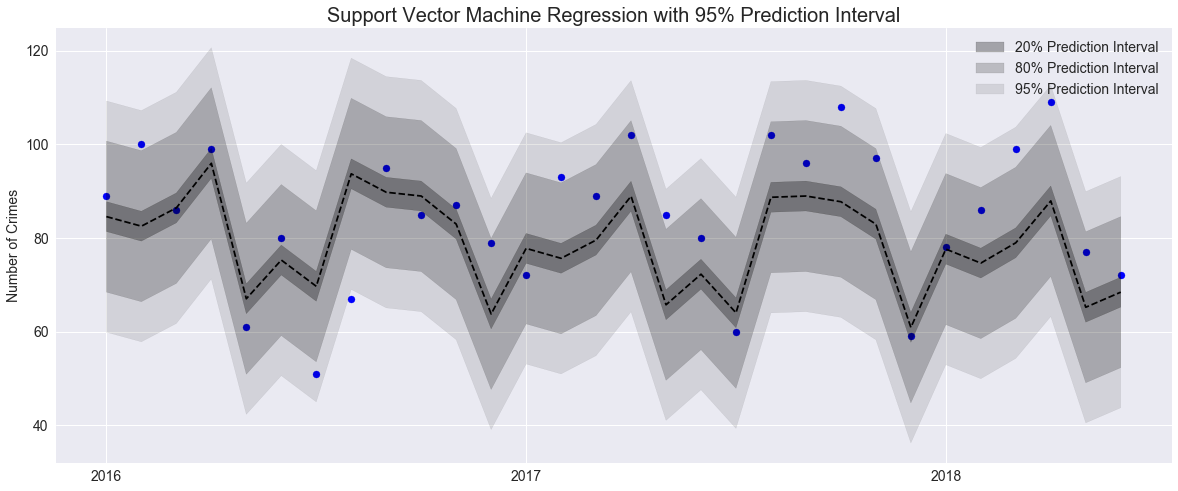

In [28]:
#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
y_pred_svr = pipeline_svr.predict(X_test)
summary_statistics(y_test, y_pred_svr, len(X_train[0]), test=True)
plot_fit(y_test, y_pred_svr, ax=ax, test=True, test_mse=best_mse_svr)
ax.set_title('Support Vector Machine Regression with 95% Prediction Interval');

The support vector machine regression is the best so far. The RMSE is again significantly reduced, and for the first time the R-squared is positive with a value around 0.2794. It appears to follow the general shape of the data pretty well, however, the trends accuracy is reduced from the elastic net regression to 17/29.

### D. Random Forest Regression

MSE: 189.7193
RMSE: 13.7739
R-squared: 0.1453
Trends accuracy: 0.7241 or 21/29


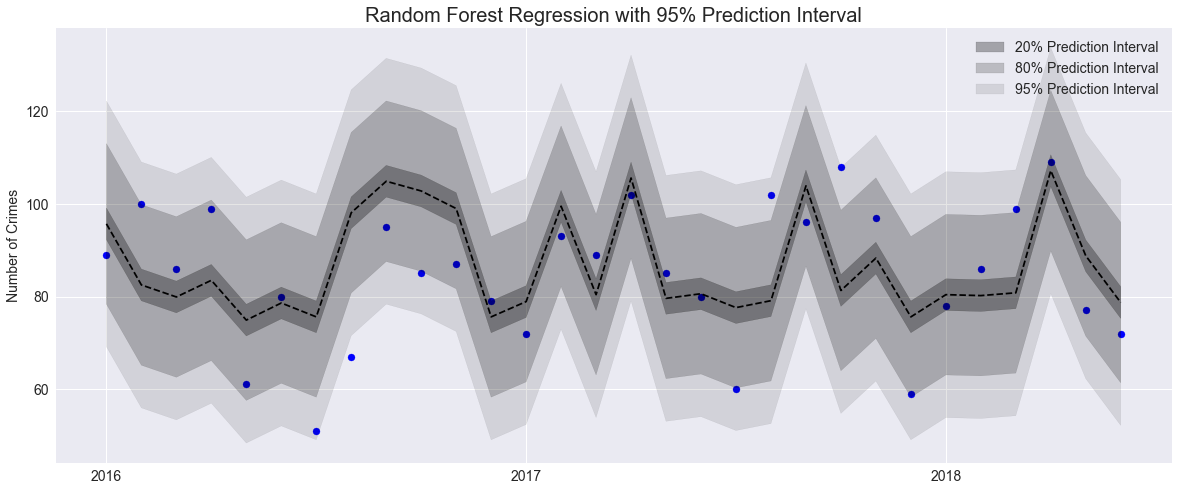

In [29]:
#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
y_pred_rf = pipeline_rf.predict(X_test)
summary_statistics(y_test, y_pred_rf, len(X_train[0]), test=True)
plot_fit(y_test, y_pred_rf, ax=ax, test=True, test_mse=best_mse_rf)
ax.set_title('Random Forest Regression with 95% Prediction Interval');

The random forest regression beats the elastic net with a better R-squared and equal trends accuracy of 21/29. It has a better trends accuracy than the support vector machine regression, however, its RMSE and R-squared are lower.

### E. Gradient Boosting Regression

MSE: 147.5279
RMSE: 12.1461
R-squared: 0.3354
Trends accuracy: 0.8276 or 24/29


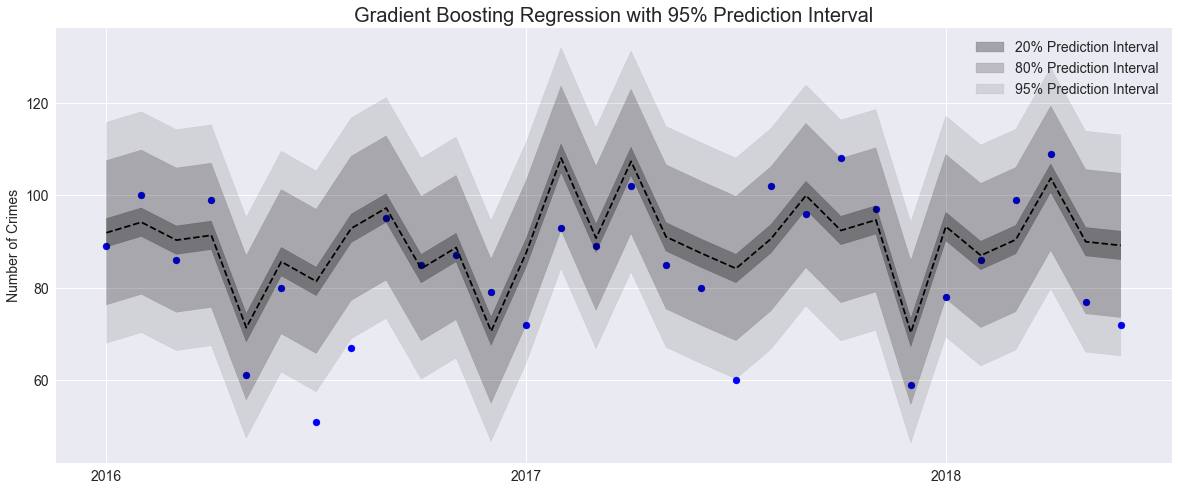

In [30]:
#plotting results
fig, ax = plt.subplots(figsize=(20, 8))
y_pred_gb = pipeline_gb.predict(X_test)
summary_statistics(y_test, y_pred_gb, len(X_train[0]), test=True)
plot_fit(y_test, y_pred_gb, ax=ax, test=True, test_mse=best_mse_gb)
ax.set_title('Gradient Boosting Regression with 95% Prediction Interval');

Gradient boosting performs better than the other models in every metric. It has the highest trends accuracy by far with 24/29, as well as the lowest RMSE, and the highest R-squared with around 12.15 and 0.34 respectively. This seems like the best model for our data.

# V. Forecasting Future Crime Levels

To forecast future crime levels, we have to change the regression model slightly. Currently it relies on lagged numbers of crime and some of these numbers will become unavailable once we forecast beyond one month into the future. For each month past one month into the future, we will remove one additional feature from the predictor matrix. Since these features are among the most important, we can expect the predictive accuracy of our model to decrease the further into the future it predicts.

The current prediction intervals are created using the MSE obtained during cross-validation. Since we can expect the MSE to increase for each further month we forecast, we will need to find each $MSE_j$ for predicting $j \in \{1,2,3, 4, 5\}$ months into the future. Finding the actual values for our sophisticated model is difficult if not impossible, so we will need to approximate them by simulating predicting $j$ months into the future. We can do this by cross-validating again with the corresponding lagged features removed, and calculating each individual $MSE_j$.

In [31]:
#list of lagged RMSE's
rmse_list = np.append([np.sqrt(best_mse_gb)], np.empty(5))

#calculating rmse for each number of months into the future
for lag in range(1, 6):
    #features to drop
    cols = []
    for i in range(1, lag+1):
        cols.append('past_num_crimes_{}'.format(i))
    #cross validating on data with best params and finding rmse
    _, mse = grid_search_cv(pipeline_gb, X.drop(columns=cols).values, y,
                   param_names=['regression__max_depth'], param_vals=[[10]])
    rmse_list[lag] = np.sqrt(mse)
    
for i, rmse in enumerate(rmse_list):
    print('RMSE for predicting {} month(s) into the future: {}'.format(i+1, rmse_list[i]))

RMSE for predicting 1 month(s) into the future: 12.20863687311311
RMSE for predicting 2 month(s) into the future: 12.294813896441598
RMSE for predicting 3 month(s) into the future: 13.371122385665332
RMSE for predicting 4 month(s) into the future: 12.575096625595028
RMSE for predicting 5 month(s) into the future: 12.502391956425768
RMSE for predicting 6 month(s) into the future: 12.637258455060056


Interestingly, the RMSE does not increase quickly as we predict into the future (note that predicting 1 month into the future should not change from our original rmse calculation). It looks like some of the higher lags and the other features are more important to predicting crime levels. In fact, these may not be statistically significantly different from the original RMSE of 12.20. Still, we will use a conservative estimate and use the highest RMSE for predicting past 3 months into the future.

Now we can begin forecasting.

In [32]:
#setting estimate for rmse for future predictions
rmse_list[2:] = rmse_list[2]

#data to forecast on
X_forecast = f.drop(columns='num_crimes').iloc[-6:]
y_forecast = np.empty(6)

#forecasting July through December 2018 individually
for lag in range(6):
    #features to drop
    cols = []
    #dropping features for every month but July
    for i in range(1, lag+1):
        cols.append('past_num_crimes_{}'.format(i))
    #fitting to entire data with appropriate dropped columns
    pipeline_gb.fit(X.drop(columns=cols).values, y)
    #extracting sample to use for prediction
    sample = X_forecast.loc[(2018, 7+lag), :].drop(cols).values
    #predicting based on one month sample
    y_forecast[lag] = pipeline_gb.predict(sample.reshape(1, -1))
    
#printing point estimates
for i, month in enumerate(['July', 'August', 'September', 'October', 'November', 'December']):
    print('Forecasted number of crimes for {}, 2018: {}'.format(month, int(y_forecast[i])))

Forecasted number of crimes for July, 2018: 61
Forecasted number of crimes for August, 2018: 90
Forecasted number of crimes for September, 2018: 94
Forecasted number of crimes for October, 2018: 111
Forecasted number of crimes for November, 2018: 91
Forecasted number of crimes for December, 2018: 58


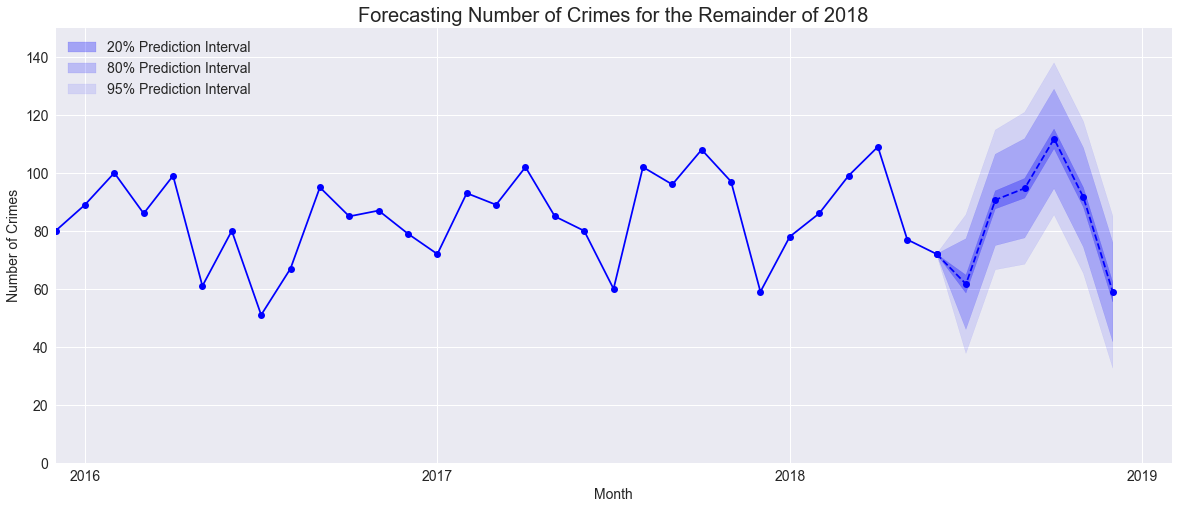

In [33]:
plt.figure(figsize=(20, 8))

#plotting observed data
plt.plot(range(len(y)), y, color='b', linestyle='-', marker='o')
#plotting forecasted estimates
plt.plot(range(len(y)-1 , len(y)+len(y_forecast)), np.append(y[-1], y_forecast),
         color='b', marker='o', linestyle='--', )

#calculating prediction intervals
y_upper_20 = np.append(y[-1], y_forecast + .253*rmse_list)
y_lower_20 = np.append(y[-1], y_forecast - .253*rmse_list)
y_upper_80 = np.append(y[-1], y_forecast + 1.28*rmse_list)
y_lower_80 = np.append(y[-1], y_forecast - 1.28*rmse_list)
y_upper_95 = np.append(y[-1], y_forecast + 1.96*rmse_list)
y_lower_95 = np.append(y[-1], y_forecast - 1.96*rmse_list)

#plotting prediction intervals
size = len(y_forecast)
plt.fill(list(range(101, 102+size)) + list(range(102+size-1, 100, -1)),
                np.concatenate((y_upper_20, y_lower_20[::-1])), alpha=0.3, color='b', label='20% Prediction Interval')
plt.fill(list(range(101, 102+size)) + list(range(102+size-1, 100, -1)),
                np.concatenate((y_upper_80, y_lower_80[::-1])), alpha=0.2, color='b', label='80% Prediction Interval')
plt.fill(list(range(101, 102+size)) + list(range(102+size-1, 100, -1)),
                np.concatenate((y_upper_95, y_lower_95[::-1])), alpha=0.1, color='b', label='95% Prediction Interval')
#formatting
plt.title('Forecasting Number of Crimes for the Remainder of 2018')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.xticks(range(0, 120, 12), range(2010, 2020))
plt.xlim(71, 109)
plt.ylim(0, 150)
plt.show()